## Sentiment analysis
Se trabajará con el problema de identificar el sentimiento de un texto  como *positivo* o *negativo*...

> a) Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.

In [1]:
import pandas as pd
ftr = open("train_data.csv", "r",encoding='latin9')
fts = open("test_data.csv", "r",encoding='latin9')
rows = [line.split(" ",1) for line in ftr.readlines()]
df_train = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_train['Sentiment'] = pd.to_numeric(df_train['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
df_test = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_test['Sentiment'] = pd.to_numeric(df_test['Sentiment'])
df_train.shape

(3554, 2)

In [2]:
df_train.head()

,Sentiment,Text
0,-1,"everything's serious , poetic , earnest and --..."
1,-1,"narratively , trouble every day is a plodding ..."
2,1,a truly wonderful tale combined with stunning ...
3,1,jason patric and ray liotta make for one splen...
4,-1,haneke keeps us at arm's length . guided more ...


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554 entries, 0 to 3553
Data columns (total 2 columns):
Sentiment    3554 non-null int64
Text         3554 non-null object
dtypes: int64(1), object(1)
memory usage: 55.6+ KB


In [7]:
df_train["Sentiment"].unique()

array([-1,  1])

In [8]:
df_train["Sentiment"].value_counts()

-1    1784
 1    1770
Name: Sentiment, dtype: int64

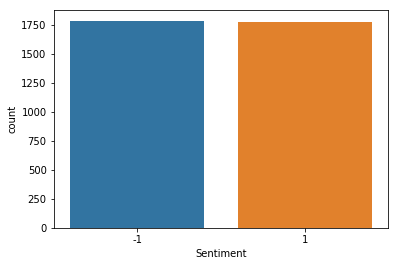

In [10]:
import seaborn as sns
%matplotlib inline
sns.countplot(x= "Sentiment",data=df_train)

El dataset tiene dos clases, codificadas como "-1" y "1". El problema es de clasificación binaria con las clases balanceadas.  
El texto de entrada no está estructurado ya que es extraído de redes sociales, por lo que necesita un preprocesamiento.

> b) Construya un conjunto de validación (también conocido como *hold out validation*), a través de una máscara aleatoria, para verificar los resultados de los algoritmos.

In [13]:
df_train.shape

(3554, 2)

In [11]:
import numpy as np
msk = np.random.rand(len(df_train)) < 0.8
df_new_train = df_train[msk]
df_val = df_train[~msk]

In [12]:
df_new_train.shape

(2871, 2)

In [14]:
df_val.shape

(683, 2)

Se redujo el conjunto de entrenamiento al 80% de los datos para poder tener un conjunto de validación fijo de aproximadamente 700 ejemplos.

> c) Implemente y explique un pre-procesamiento para los tweets para dejarlos en un formato estándarizado en el cual se podrán trabajar.

In [15]:
df_new_train["Text"]

0       everything's serious , poetic , earnest and --...
1       narratively , trouble every day is a plodding ...
3       jason patric and ray liotta make for one splen...
5       richard pryor mined his personal horrors and c...
6       puts on airs of a hal hartley wannabe film -- ...
7       the characters are interesting and the relatio...
8       this long and relentlessly saccharine film is ...
9       the movie's progression into rambling incohere...
10        as lively an account as seinfeld is deadpan .\n
11      a damn fine and a truly distinctive and a deep...
12      [tries] to parody a genre that's already a jok...
13      there are as many misses as hits , but ultimat...
15                          schindler's list it ain't .\n
16      it just goes to show , an intelligent person i...
17      a bracing , unblinking work that serves as a p...
18      cage makes an unusual but pleasantly haunting ...
19                     adaptation is simply brilliant .\n
21      a roma

In [18]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer
def word_extractor1(text):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower())for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words
def word_extractor2(text):
    wordstemmer = PorterStemmer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordstemmer.stem(word.lower())for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words
print(word_extractor1("I love to eat cake"))
print(word_extractor1("I love eating cake"))
print(word_extractor1("I loved eating the cake"))
print(word_extractor1("I do not love eating cake"))
print(word_extractor1("I don't love eating cake"))

 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 n't love eating cake


In [19]:
print(word_extractor2("I love to eat cake"))
print(word_extractor2("I love eating cake"))
print(word_extractor2("I loved eating the cake"))
print(word_extractor2("I do not love eating cake"))
print(word_extractor2("I don't love eating cake"))

 love eat cake
 love eat cake
 love eat cake
 love eat cake
 n't love eat cake


Se utilizan dos pre-procesamientos para trabajar y compararlos.
1. Se eliminan los números y puntuaciones
2. Se pasa el texto a minúsculas
3. Se eliminan las *stopwords*
4. Se realiza un proceso de *stemming*/*lemmatizer*

Así obtener textos mas normalizados en su estructura y un vocabulario reducido de palabras únicas.

> d) Utilizando la función *CountVectorizer* de la librerı́a sklearn genere una representación vectorial del texto de entrenamiento y del conjunto que usaremos para realizar la validación. Esta función consiste en contar cuántas veces aparecen ciertos términos/palabras en el texto a través de un vocabulario que construiremos mediante la unión de todas las palabras que observemos en los textos que tenemos a disposición. Explore el vocabulario utilizado y determine cuáles son las palabras más frecuentes en el conjunto de entrenamiento y validación.

In [21]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
texts_train1 = [word_extractor1(text) for text in df_new_train.Text]
texts_val1 = [word_extractor1(text) for text in df_val.Text]
texts_train2 = [word_extractor2(text) for text in df_new_train.Text]
texts_val2 = [word_extractor2(text) for text in df_val.Text]

vectorizer1 = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer1.fit(np.asarray(texts_train1))
vectorizer2 = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer2.fit(np.asarray(texts_train2))

features_train1 = vectorizer1.transform(texts_train1)
features_val1 = vectorizer1.transform(texts_val1)
features_train2 = vectorizer1.transform(texts_train2)
features_val2 = vectorizer1.transform(texts_val2)

labels_train = np.asarray((df_new_train.Sentiment.astype(float)+1)/2.0)
labels_val = np.asarray((df_val.Sentiment.astype(float)+1)/2.0)

In [24]:
features_train1

<2871x8673 sparse matrix of type '<type 'numpy.int64'>'
	with 30713 stored elements in Compressed Sparse Row format>

In [26]:
len(vocab)

7177

In [28]:
vocab = vectorizer1.get_feature_names()
dist=list(np.array(features_train1.sum(axis=0)).reshape(-1,))
for tag, count in zip(vocab, dist):
    print count, tag

5 10
3 100
2 101
1 10th
3 11
1 110
1 11th
1 12
2 13
1 13th
1 14
1 140
2 15
1 16
1 163
1 170
1 18th
3 19
2 1915
1 1934
1 1938
1 1940s
2 1950
1 1950s
1 1954
1 1955
1 1958
1 1959
2 1960s
1 1972
3 1975
2 1980
1 1991
2 1995
2 19th
2 20
2 2000
6 2002
2 21st
1 22
1 24
1 25s
2 30
1 300
2 3000
1 37
1 3d
5 40
1 400
1 401
1 451
1 48
1 49
4 4ever
3 50
2 51
1 53
1 5ths
1 60s
1 65
1 65th
3 70s
1 71
1 77
1 78
4 80
1 800
3 80s
2 84
2 85
1 88
1 8th
10 90
1 90s
1 94
2 95
1 96
1 97
2 99
1 aaliyah
2 abandon
1 abandono
1 abbass
1 abbreviated
1 abc
2 abel
1 abhorrent
1 abiding
10 ability
5 able
3 ably
1 aboul
2 above
1 abrahams
1 abrams
1 abrasive
2 abroad
1 abruptly
2 absolute
6 absolutely
1 absorb
1 absorbed
8 absorbing
3 abstract
1 absurd
2 absurdist
4 absurdity
1 absurdly
1 aburrido
4 abuse
1 abysmally
1 acabamos
1 academic
2 academy
5 accent
1 accentuating
2 accept
1 accepting
9 accessible
2 accident
1 accidental
2 accompanying
4 accomplished
1 accomplishes
1 accomplishment
1 according
8 account
1 accu

1 consigliere
1 consigned
1 consistency
3 consistently
1 consolation
1 conspicuously
1 conspiracy
3 constant
7 constantly
1 constatao
1 constricted
5 construct
4 constructed
3 construction
2 consuming
1 consummate
1 contagious
1 contain
1 contained
5 contains
1 contemplates
1 contemplation
1 contemplative
8 contemporary
1 contemptuous
1 contend
3 content
2 contest
6 context
1 continual
1 continuation
3 continues
1 continuing
1 contorting
2 contradiction
2 contradictory
1 contradicts
2 contraption
1 contrary
1 contrast
1 contrasting
1 contributed
1 contribution
3 contrivance
7 contrived
6 control
2 controlled
1 controversy
1 contructed
1 convence
1 convenient
2 convention
6 conventional
5 conversation
1 conversational
1 convert
2 converted
3 convey
2 conveying
1 conveys
1 convict
2 conviction
3 convince
1 convinced
6 convincing
3 convoluted
1 convolution
1 cook
1 cooker
10 cool
1 coolidge
6 cop
2 cope
1 coping
1 copout
4 coppola
2 copy
1 corbett
3 core
1 corn
2 corner
3 corny
2 corporat

1 girls
43 give
15 given
3 giving
1 glamorous
1 glamour
1 glancing
3 glass
2 glib
1 glide
7 glimpse
1 glinting
1 glorification
1 glorified
1 glorious
2 gloriously
3 glory
2 gloss
2 glossy
1 glow
1 glued
1 gluing
2 glum
1 gnashing
46 go
2 goal
1 gobbler
5 god
3 godard
1 goddammit
1 godfrey
2 godzilla
1 goers
1 goggles
21 going
2 gold
1 goldbacher
2 goldie
1 golf
1 gondry
8 gone
1 gong
1 goo
116 good
1 goodall
2 goodfellas
1 gooding
2 goodness
1 goodwill
1 goody
2 goofball
1 goofiness
6 goofy
1 goose
3 gore
2 gored
1 gorefests
10 gorgeous
1 gorgeously
1 gorgeousness
4 gory
2 gosford
1 gosh
1 gosto
7 got
2 gothic
1 gotten
2 gourmet
1 governance
1 governmental
2 grab
10 grace
1 graced
1 graceland
1 graceless
4 grade
2 gradually
1 graffiti
1 graham
2 grain
1 grainy
4 grand
1 grandes
4 grandeur
1 grandiosa
1 grandiosity
1 grandkids
1 grandly
1 grandparent
2 grandson
1 granger
6 grant
5 graphic
1 graphically
4 grasp
1 grass
1 grateful
1 gratifying
3 grating
1 gratuitous
2 grave
1 graveyard
1 

2 murderous
1 murkiest
3 murky
4 murphy
2 muse
1 museum
22 music
8 musical
2 musician
1 musing
2 musketeer
1 musset
10 must
1 mute
4 muted
1 muting
1 muttering
1 muzak
1 myriad
2 mysterious
15 mystery
2 mystical
2 mythic
2 mythology
1 nachtwey
1 nadir
1 naf
1 nail
1 nailbiter
4 nair
1 naivet
1 nakedness
1 nalin
11 name
2 named
1 namely
1 nanosecond
1 naomi
2 nap
1 naptime
2 narc
2 narcissism
1 narcissist
1 narcotic
2 narrated
1 narration
20 narrative
2 narratively
1 narrator
1 narrow
4 nasty
1 natalie
5 nation
2 national
1 nationalist
2 native
1 natter
6 natural
1 naturalism
1 naturalistic
1 naturally
7 nature
1 natured
1 naturedness
1 nauseating
1 nazi
10 near
12 nearly
1 neat
1 nebrida
3 necessarily
6 necessary
1 neck
23 need
4 needed
1 needle
2 needlessly
1 needy
1 negar
2 negative
2 neglected
1 neglecting
1 negligible
1 neighborhood
1 neil
15 neither
2 nemesis
1 neo
6 nerve
1 nerved
3 nervous
2 nervy
1 nettelbeck
1 network
1 neurasthenic
1 neurotic
74 never
3 neverland
1 neverthele

2 shadowy
1 shafer
2 shaggy
1 shagster
2 shainberg
2 shake
4 shakespeare
1 shakesperean
1 shaky
1 shall
4 shallow
2 sham
1 shamble
6 shame
1 shamefully
1 shamelessly
2 shanghai
2 shape
4 shaped
1 shapeless
1 shapelessly
1 shaping
7 share
1 sharing
1 shark
5 sharp
1 sharpie
1 shatner
1 shattering
1 shave
1 she
1 shear
2 shed
1 shedding
1 sheep
7 sheer
1 sheet
1 shekhar
3 shelf
1 shelved
1 shepard
1 shield
2 shift
2 shifting
2 shimmering
5 shine
2 shiner
2 shining
1 shiny
1 shinya
3 ship
1 shirley
1 shmear
8 shock
4 shocked
1 shocker
1 shocking
2 shockingly
1 shoddy
2 shoe
1 shook
4 shoot
5 shooting
1 shop
1 shopping
2 shore
23 short
1 shortcoming
1 shorter
1 shortest
1 shortness
1 shorty
18 shot
4 shoulder
2 shout
1 shoving
39 show
4 showcase
1 showdown
1 shower
2 showgirl
6 showing
1 shown
3 showtime
1 showy
2 shrek
2 shrewd
1 shrug
1 shtick
1 shun
3 shut
3 shyamalan
1 siberian
1 sibling
3 sick
1 sickeningly
1 sickly
9 side
1 sidey
1 siege
1 siegel
1 siempre
1 sieve
6 sight
5 sign
1 si

1 wittgenstein
1 wittier
12 witty
1 wizard
1 wizardry
1 wizened
19 wo
1 wobbly
1 woefully
1 wollter
1 wolodarsky
27 woman
7 wonder
3 wonderful
6 wonderfully
3 wondering
1 wonderment
1 wonderous
1 wondrous
1 wondrously
1 wong
1 wonton
4 woo
1 wood
2 wooden
1 woodman
4 woody
1 woozy
14 word
1 wordy
88 work
1 workaday
5 worked
1 worker
9 working
1 workman
2 workout
1 workshop
35 world
1 worldview
2 worn
3 worry
1 worrying
9 worse
2 worship
13 worst
16 worth
2 worthless
6 worthwhile
10 worthy
66 would
1 wound
1 wounded
1 wounding
1 woven
5 wow
2 wrap
3 wrapped
1 wrapping
1 wreaked
4 wreck
1 wreckage
3 wrench
3 wrenching
1 wretched
1 wrist
1 write
25 writer
1 writers
1 writhing
9 writing
14 written
11 wrong
5 wrote
5 wry
1 wwf
2 wwii
1 xerox
1 xmas
5 xx
3 ya
1 yacht
1 yammering
1 yard
7 yarn
2 yawn
1 yawning
1 yeah
56 year
1 yearn
2 years
1 yellow
12 yes
1 yesterday
35 yet
1 yiddish
2 yield
4 york
1 yorkers
1 yosuke
21 young
1 younger
3 youngster
2 your
1 yourself
2 youth
1 youthful
2 yu
1 

In [29]:
len(vocab)

8673

In [30]:
vocab = vectorizer2.get_feature_names()
dist=list(np.array(features_train2.sum(axis=0)).reshape(-1,))
for tag, count in zip(vocab, dist):
    print count, tag

5 10
3 100
2 101
1 10th
3 11
1 110
1 11th
1 12
2 13
1 13th
1 14
1 140
2 15
1 16
1 163
1 170
1 18th
3 19
2 1915
1 1934
1 1938
0 1940
3 1950
0 1954
1 1955
1 1958
1 1959
1 1960
0 1972
1 1975
3 1980
2 1991
1 1995
2 19th
2 20
2 2000
2 2002
6 21st
2 22
1 24
1 25
0 30
2 300
1 3000
2 37
1 3d
1 40
5 400
1 401
1 451
1 48
1 49
1 4ever
4 50
3 51
2 53
1 5th
0 60s
1 65
1 65th
1 70
0 71
1 77
1 78
1 80
7 800
1 84
0 85
2 88
2 8th
1 90
1 94
11 95
0 96
1 97
2 99
1 aaliyah
1 abandon
2 abandono
1 abbass
2 abbrevi
1 abc
1 abel
0 abhorr
1 abid
2 abil
0 abl
0 abli
0 aboul
0 abov
0 above
1 abraham
2 abram
0 abras
0 abroad
0 abruptli
2 absolut
0 absorb
0 abstract
0 absurd
10 absurdist
0 absurdli
0 aburrido
3 abus
5 abysm
2 acabamo
0 academ
0 academi
1 accent
0 accentu
0 accept
0 access
0 accid
0 accident
5 accompani
0 accomplish
3 accord
0 account
0 accumul
2 accur
0 acerta
0 ach
0 achiev
0 achil
0 achingli
0 achiv
8 achronolog
0 acid
0 acknowledg
0 acquir
1 acr
0 acrid
0 across
0 act
0 acting
0 action
0 activ


3 demograph
0 demon
0 demonstr
0 deni
0 denial
0 deniro
0 denmark
1 denouement
1 dens
10 dentist
0 denzel
6 deok
3 depart
0 departur
1 depend
4 deperson
0 depict
1 deplet
2 deplor
1 deposit
2 deprav
0 depress
1 depressingli
0 depth
0 der
0 derid
4 deriv
0 derrida
1 derring
0 desaponta
1 descompromissado
58 describ
1 descript
6 dese
0 deserv
2 design
1 desir
0 desol
0 despair
0 despairingli
0 desper
0 despis
0 despit
0 desta
2 destin
0 destini
1 destroy
0 destruct
3 detail
0 detect
0 detent
0 deterior
0 determin
1 detox
3 detract
5 detriment
1 deuc
0 devast
0 devastatingli
0 develop
9 development
0 deviant
2 devic
1 devil
0 devis
1 devito
0 devo
4 devoid
0 devolv
1 devot
0 dexter
0 diabol
2 dialog
0 dialogu
0 diamond
0 dian
0 diari
0 diaz
0 dici
0 dicken
0 dictum
0 didactic
2 die
0 diesel
0 diferena
0 differ
1 difficult
0 dig
0 digit
0 digniti
7 digress
0 dilut
0 dimens
1 dimension
1 diminish
1 dimwit
0 dinner
0 diplomat
1 dire
2 direct
5 directli
1 director
18 directori
1 directress
0 

0 improvis
0 impuls
1 in
0 inact
0 inadvert
1 inan
16 inappropri
1 inarticul
2 inc
0 incarn
1 incess
0 incessantli
0 inch
0 incid
0 incio
18 incis
1 includ
1 incognito
2 incoher
4 incompet
1 incomprehens
6 incongru
1 inconsequenti
1 inconsist
0 incorpor
0 increas
1 increasingli
2 incred
0 inde
1 indel
1 independ
1 independent
2 indi
1 indian
0 indic
1 indict
7 indie
2 indiffer
2 indistinct
0 individu
0 induc
1 inducingli
1 indulg
6 industri
4 ineff
1 ineleg
0 inept
0 inequ
0 inert
0 inertia
0 inescap
0 inevit
0 inexcus
0 inexor
0 inexperienc
0 inexplic
0 inexpress
0 infami
0 infant
0 infantil
0 infatu
0 infecti
0 infidel
0 infiltr
1 infinit
0 inflat
2 inflict
1 influenc
91 infomerci
0 inform
3 infrequ
7 infuri
0 infus
1 ingeni
9 ingenu
1 ingredi
3 inher
4 inhospit
0 initi
0 inject
1 injuri
0 ink
1 inmat
2 inner
1 innoc
1 innocu
0 innov
1 inoffens
23 insan
1 inscrut
1 insecur
46 insid
15 inside
0 insight
0 insignific
1 insipid
0 insist
3 insomnia
2 inspir
1 instal
0 instanc
0 instantli


0 preschool
0 prescrib
4 presenc
0 present
4 preserv
0 press
0 pressur
7 presum
0 preteen
1 pretend
1 pretens
1 pretenti
0 pretti
8 prevail
0 prevent
0 preview
1 previou
1 prewarn
0 prey
0 price
0 priceless
0 pride
12 prim
0 primal
0 primarili
0 prime
0 primit
6 princip
0 principl
0 print
0 prism
0 prison
0 prissi
0 pristin
0 privat
0 privileg
1 prize
1 pro
1 probabl
1 probe
10 problem
3 problema
0 problemat
0 proce
1 procedur
1 proceed
2 process
3 processor
0 produc
1 product
2 profesor
1 profession
45 professor
0 profici
0 profil
4 profound
4 profoundli
0 profund
4 progenitor
1 program
0 programa
0 progress
0 project
1 promin
3 promis
3 promisingli
0 promot
31 pron
0 pronounc
9 proof
1 prop
2 propaganda
0 propel
2 proper
0 properti
0 propheci
1 prophet
3 proport
0 prose
1 prospect
0 prostitut
6 protagonist
1 protestor
1 protract
0 proud
0 prove
1 proven
1 provid
0 provoc
2 provok
0 prowess
0 prozac
0 prurient
0 pryor
0 pseudo
0 psych
2 psychedel
0 psychic
0 psycholog
0 psychopathi
19

6 turntabl
1 turpin
2 turturro
1 tutori
0 tuxedo
0 tv
0 twaddl
0 tweak
1 tweedi
1 twenty
0 twentysometh
0 twice
0 twin
0 twinki
0 twinkl
0 twirl
0 twist
0 twisti
0 twitchi
3 two
1 type
0 typic
0 typifi
9 ugli
0 uk
0 ultim
1 ultra
1 ultraviol
0 um
3 uma
32 un
0 una
0 unabash
4 unabashedli
1 unabl
1 unamus
1 unansw
0 unapologet
4 unashamedli
0 unassum
1 unattract
2 unawar
0 unbalanc
2 unbear
1 unbeliev
0 unblink
0 unbridl
0 uncanni
1 unceas
5 uncertain
44 uncertainti
0 uncinemat
1 uncl
3 unclassifi
2 unclear
2 unclutt
1 uncomfort
1 uncommonli
1 uncompromis
0 unconnect
1 uncontrol
2 unconvent
0 unconvinc
1 uncoordin
1 undemand
8 undeni
2 under
0 underappreci
0 underbelli
10 undercov
1 undercurr
1 undercut
0 underdog
0 underestim
4 undergradu
0 underli
9 undermin
0 underneath
1 undernourish
1 underst
0 understand
1 underwear
1 undisput
1 undistinguish
0 undo
7 undogmat
0 undon
0 undoubtedli
4 undress
0 uneas
1 uneasili
32 unembarrass
0 unemot
0 unencourag
19 unengag
0 unessenti
0 unev
0 un

In [31]:
len(vocab)

7177

El vocabulario generado para las dos representaciones es distintas, por lo que el problema será distinto

In [33]:
features_train1

<2871x8673 sparse matrix of type '<type 'numpy.int64'>'
	with 30713 stored elements in Compressed Sparse Row format>

In [34]:
features_train2

<2871x8673 sparse matrix of type '<type 'numpy.int64'>'
	with 20530 stored elements in Compressed Sparse Row format>

In [56]:
vocab = vectorizer2.get_feature_names()
dist=list(np.array(features_train2.sum(axis=0)).reshape(-1,))
lista = zip(vocab, dist)
lista.sort(key=lambda x: x[1],reverse=True)
lista_ordenada = lista

In [57]:
lista_ordenada[:10]

[(u'heaven', 464),
 (u'pace', 219),
 (u'rubbo', 197),
 (u'juliet', 183),
 (u'piesiewicz', 157),
 (u'gentli', 123),
 (u'interrupt', 118),
 (u'expos', 109),
 (u'ravag', 106),
 (u'era', 94)]

In [53]:
vocab = vectorizer1.get_feature_names()
dist=list(np.array(features_train1.sum(axis=0)).reshape(-1,))
lista = zip(vocab, dist)
lista.sort(key=lambda x: x[1],reverse=True)
lista_ordenada = lista

In [55]:
lista_ordenada[:10]

[(u'film', 459),
 (u'movie', 377),
 (u'like', 200),
 (u'one', 197),
 (u'ha', 183),
 (u'story', 140),
 (u'make', 134),
 (u'character', 128),
 (u'even', 122),
 (u'good', 116)]

En la celda anterior se muestran las palabras más frecuentes de cada representación generada, mostrándo que resultan no ser iguales, evidenciando la diferente representación generada.

> e) Construya una función que entrene/ajuste un modelo de Regresión Logı́stica y mida el error de predicción obtenido sobre los datos de entrenamiento y validación. Experimente con variar la representación o preprocesamiento, por ejemplo el efecto de filtrar *stopwords* y de eliminar este paso de pre-procesamiento tı́pico. Determine además, qué representación obtiene un mejor resultado: si aquella obtenida vı́a lematización o aquella obtenida vı́a *stemming*. Seleccione el mejor modelo y mida sobre *test*. Comente

In [58]:
labels_train

array([0., 0., 1., ..., 0., 1., 0.])

In [59]:
from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xv,yv):
    model = LogisticRegression()
    model = model.fit(x, y)
    print("Accuracy under training: ",model.score(x,y))
    print("Accuracy under validation: ",model.score(xv,yv))
    return model

In [60]:
log_model1 = do_LOGIT(features_train1,labels_train,features_val1,labels_val)

('Accuracy under training: ', 0.991292232671543)
('Accuracy under validation: ', 0.7335285505124451)


In [62]:
log_model1.predict(features_train1)

array([0., 0., 1., ..., 0., 1., 0.])

In [63]:
log_model1.predict_proba(features_train1)

array([[0.93404428, 0.06595572],
       [0.92522694, 0.07477306],
       [0.19497929, 0.80502071],
       ...,
       [0.82279549, 0.17720451],
       [0.18786249, 0.81213751],
       [0.83868295, 0.16131705]])

In [61]:
log_model2 = do_LOGIT(features_train2,labels_train,features_val2,labels_val)

('Accuracy under training: ', 0.9292929292929293)
('Accuracy under validation: ', 0.6734992679355783)


En base a los dos modelos entrenados el mejor resulta ser con el pre-proceso 1 ( con *lematización*), gracias a que obtiene mejores resultados *accuracy* sobre el conjunto de validación.

> f) Finalmente, tome un subconjunto aleatorio de los textos de prueba y analice las predicciones del modelo (explore las predicciones, ası́ como las probabilidades que el clasificador asigna a cada clase)

In [68]:

for i,dato in enumerate(features_train1[:50]):
    print("Texto: ",df_new_train.Text.values[i])
    print("Probabilidad: ",log_model1.predict_proba(dato))

('Texto: ', "everything's serious , poetic , earnest and -- sadly -- dull .\n")
('Probabilidad: ', array([[0.93404428, 0.06595572]]))
('Texto: ', 'narratively , trouble every day is a plodding mess .\n')
('Probabilidad: ', array([[0.92522694, 0.07477306]]))
('Texto: ', 'jason patric and ray liotta make for one splendidly cast pair .\n')
('Probabilidad: ', array([[0.19497929, 0.80502071]]))
('Texto: ', "richard pryor mined his personal horrors and came up with a treasure chest of material , but lawrence gives us mostly fool's gold .\n")
('Probabilidad: ', array([[0.82691834, 0.17308166]]))
('Texto: ', 'puts on airs of a hal hartley wannabe film -- without the vital comic ingredient of the hilarious writer-director himself .\n')
('Probabilidad: ', array([[0.76417694, 0.23582306]]))
('Texto: ', "the characters are interesting and the relationship between yosuke and saeko is worth watching as it develops , but there's not enough to the story to fill two hours .\n")
('Probabilidad: ', array

## Comentarios finales (conclusiones)
Me parece importante nombrar que el pre-procesamiento es una etapa muy importante en la experimentación debido a que...